In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re  # For regular expressions

#Data Collection & Exploration
#Load the dataset
try:
    df = pd.read_csv(r"C:\Users\INDIA\Downloads\NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'NETFLIX MOVIES AND TV SHOWS CLUSTERING.csv' not found. Please ensure the file path is correct.")
    exit()

Dataset loaded successfully.


In [54]:
# Inspect the dataset structure
print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nDataset Description (Numerical Columns):")
print(df.describe())

# Identify missing values
print("\nMissing Values (Count):")
print(df.isnull().sum())

# Identify duplicate records
print("\nNumber of Duplicate Records:")
print(df.duplicated().sum())

# Remove duplicate records if any
df.drop_duplicates(inplace=True)
print(f"Duplicates removed. New shape: {df.shape}")


Dataset Head:
  show_id     type  title           director  \
0      s1  TV Show     3%                NaN   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  \
0    August 14, 2020          2020  TV-MA  4 Seasons   
1  December 23, 2016          2016  TV-MA     93 min   
2  December 20, 2018          2011      R     78 min   
3  November 16, 2017          2009  PG-13    

C:\Users\INDIA\AppData\Local\Temp\ipykernel_20356\787052983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='type', data=df, palette='viridis')


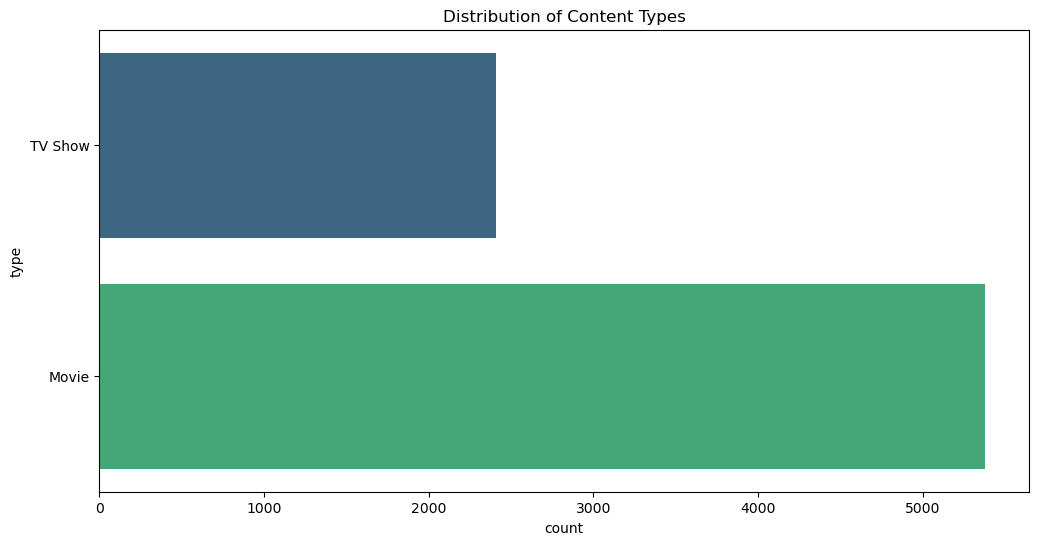

C:\Users\INDIA\AppData\Local\Temp\ipykernel_20356\787052983.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='magma')


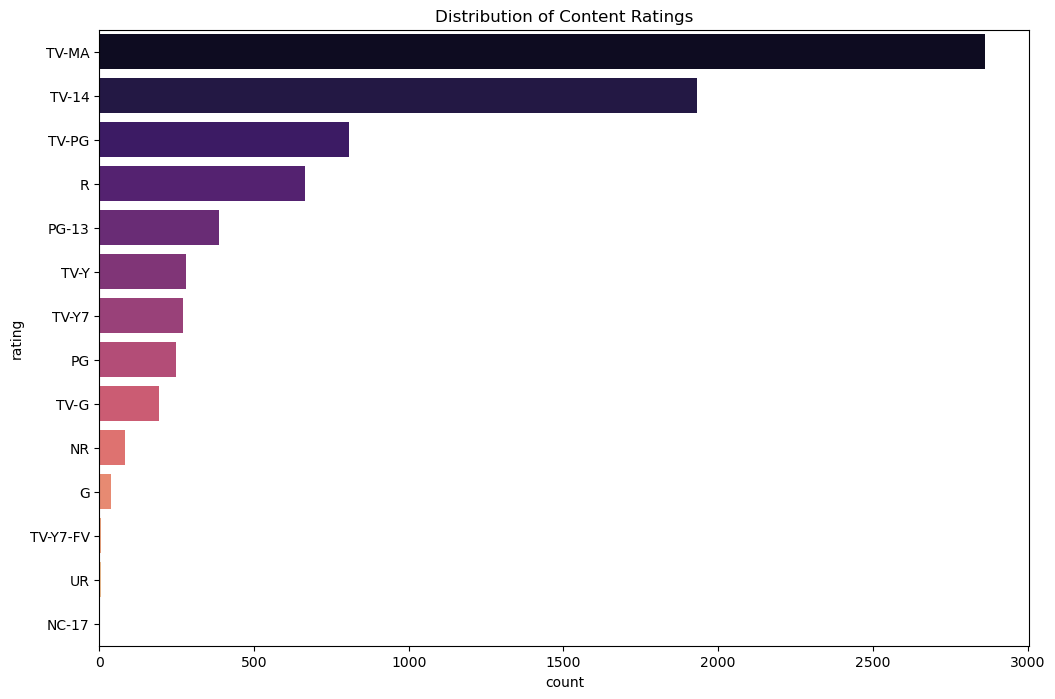

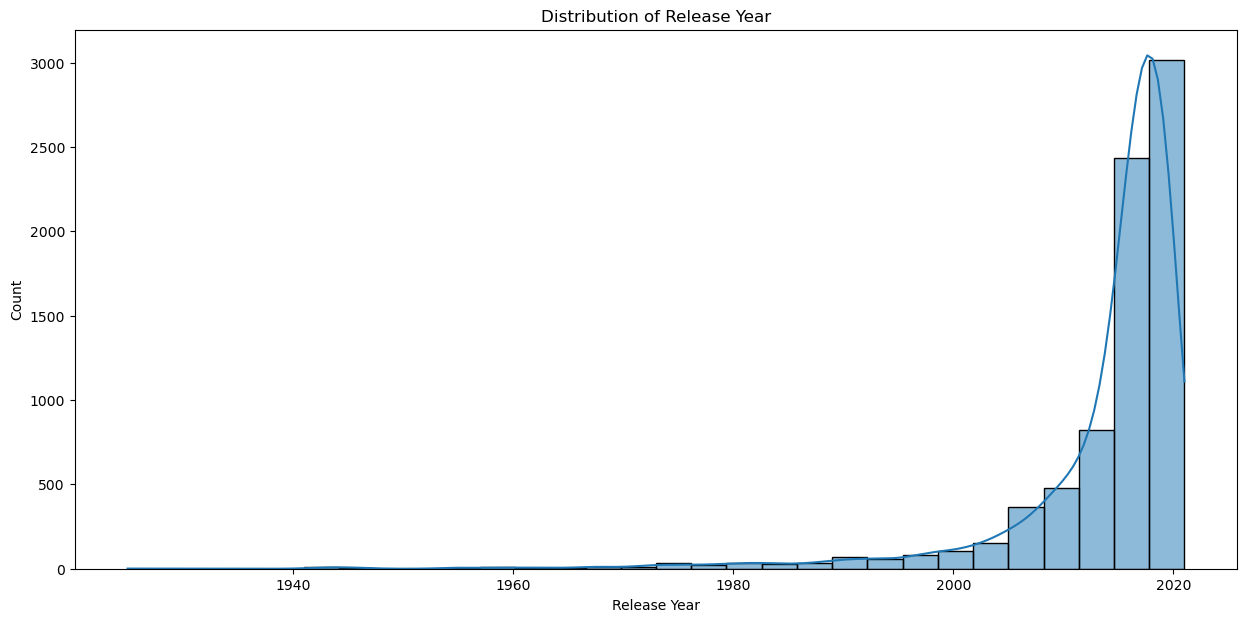

In [55]:
# Perform Exploratory Data Analysis (EDA) - Basic Visualizations
plt.figure(figsize=(12, 6))
sns.countplot(y='type', data=df, palette='viridis')
plt.title('Distribution of Content Types')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(y='rating', data=df, order=df['rating'].value_counts().index, palette='magma')
plt.title('Distribution of Content Ratings')
plt.show()

plt.figure(figsize=(15, 7))
sns.histplot(df['release_year'], bins=30, kde=True)
plt.title('Distribution of Release Year')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.show()

In [102]:
#Data Preprocessing
#Handle missing values
df['director'].fillna('Unknown', inplace=True)
df['cast'].fillna('Unknown', inplace=True)
df['country'].fillna('Unknown', inplace=True)
df['type'].fillna('Unknown', inplace=True)
df['listed_in'].fillna('Unknown', inplace=True)

#filling with mode values for rating
df['rating'].fillna(df['rating'].mode()[0], inplace=True) 

# For 'duration', fill missing values with 0 min
df['duration'].fillna('0 min', inplace=True)

# Convert duration to numerical (min for movies, season for TV shows)
def convert_duration(duration):
    if 'min' in duration:
        return int(re.findall(r'\d+', duration)[0])
    elif 'Season' in duration:
        return int(re.findall(r'\d+', duration)[0]) * 100  
    return 0

df['duration_numeric'] = df['duration'].apply(convert_duration)

#Label Encode 'type' (Movie/TV Show)
le_type = LabelEncoder()
df['type_encoded'] = le_type.fit_transform(df['type'])

#One-Hot Encode 'rating'
ohe_rating = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
rating_encoded = ohe_rating.fit_transform(df[['rating']])
rating_df = pd.DataFrame(rating_encoded, columns=ohe_rating.get_feature_names_out(['rating']), index=df.index)
df = pd.concat([df, rating_df], axis=1)

# One-hot encode 'listed_in' genres using get_dummies
genre_dummies = df['listed_in'].str.get_dummies(sep=', ')
df = pd.concat([df, genre_dummies.add_prefix('genre_')], axis=1)

#Output
print(df.head())
print(df[['duration', 'duration_numeric']].head())
print(df[['type', 'type_encoded']].head())
print(df[[col for col in df.columns if 'rating_' in col]].head())
print(df[[col for col in df.columns if col.startswith('genre_')]].head())

C:\Users\INDIA\AppData\Local\Temp\ipykernel_20356\2946046597.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['director'].fillna('Unknown', inplace=True)
C:\Users\INDIA\AppData\Local\Temp\ipykernel_20356\2946046597.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cast'].fillna('Unknown', inplace=True)
C:\Users\INDIA\AppData\Local\Temp\ipykernel_20356\2946046597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['countr

  show_id     type  title           director  \
0      s1  TV Show     3%            Unknown   
1      s2    Movie   7:19  Jorge Michel Grau   
2      s3    Movie  23:59       Gilbert Chan   
3      s4    Movie      9        Shane Acker   
4      s5    Movie     21     Robert Luketic   

                                                cast        country  \
0  João Miguel, Bianca Comparato, Michel Gomes, R...         Brazil   
1  Demián Bichir, Héctor Bonilla, Oscar Serrano, ...         Mexico   
2  Tedd Chan, Stella Chung, Henley Hii, Lawrence ...      Singapore   
3  Elijah Wood, John C. Reilly, Jennifer Connelly...  United States   
4  Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...  United States   

          date_added  release_year rating   duration  ...  \
0    August 14, 2020          2020  TV-MA  4 Seasons  ...   
1  December 23, 2016          2016  TV-MA     93 min  ...   
2  December 20, 2018          2011      R     78 min  ...   
3  November 16, 2017          2009  PG-1

In [108]:
# Standardize numerical features: 'duration_numeric', 'release_year'
scaler = StandardScaler()
df['duration_scaled'] = scaler.fit_transform(df[['duration_numeric']])
df['release_year_scaled'] = scaler.fit_transform(df[['release_year']])
print("\nNumerical features scaled.")
print(df[['duration_numeric', 'duration_scaled', 'release_year', 'release_year_scaled']].head())


Numerical features scaled.
   duration_numeric  duration_scaled  release_year  release_year_scaled
0               400         2.799086          2020             0.692878
1                93        -0.309171          2016             0.236092
2                78        -0.461040          2011            -0.334890
3                80        -0.440791          2009            -0.563284
4               123        -0.005432          2008            -0.677480


In [112]:
#Feature Engineering
# Content age: current_year - release_year
current_year = pd.to_datetime('today').year
df['content_age'] = current_year - df['release_year']
print("\n'content_age' created.")
print(df[['release_year', 'content_age']].head())

# Genre count: Number of genres associated with each content.
df['genre_count'] = df['listed_in'].apply(lambda x: len(x.split(', ')) if pd.notna(x) else 0)
print(df[['listed_in', 'genre_count']].head())

# Standardize newly created numerical features
df['content_age_scaled'] = scaler.fit_transform(df[['content_age']])
df['genre_count_scaled'] = scaler.fit_transform(df[['genre_count']])
print(df[['content_age', 'content_age_scaled', 'genre_count', 'genre_count_scaled']].head())

# Select features for clustering
features_for_clustering = [
    'type_encoded',
    'duration_scaled',
    'release_year_scaled',
    'content_age_scaled',
    'genre_count_scaled'
] + [col for col in df.columns if 'rating_' in str(col)] + \
  [col for col in df.columns if 'country_grouped_' in str(col)]


'content_age' created.
   release_year  content_age
0          2020            5
1          2016            9
2          2011           14
3          2009           16
4          2008           17
                                           listed_in  genre_count
0  International TV Shows, TV Dramas, TV Sci-Fi &...            3
1                       Dramas, International Movies            2
2                Horror Movies, International Movies            2
3  Action & Adventure, Independent Movies, Sci-Fi...            3
4                                             Dramas            1
   content_age  content_age_scaled  genre_count  genre_count_scaled
0            5           -0.692878            3            1.027634
1            9           -0.236092            2           -0.244574
2           14            0.334890            2           -0.244574
3           16            0.563284            3            1.027634
4           17            0.677480            1           -1.51678


Features selected for clustering. Shape: (7787, 61)


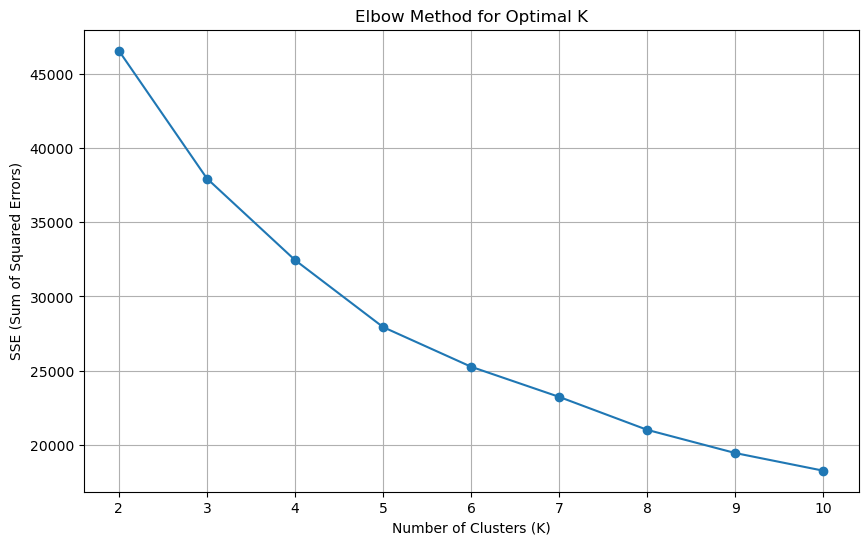

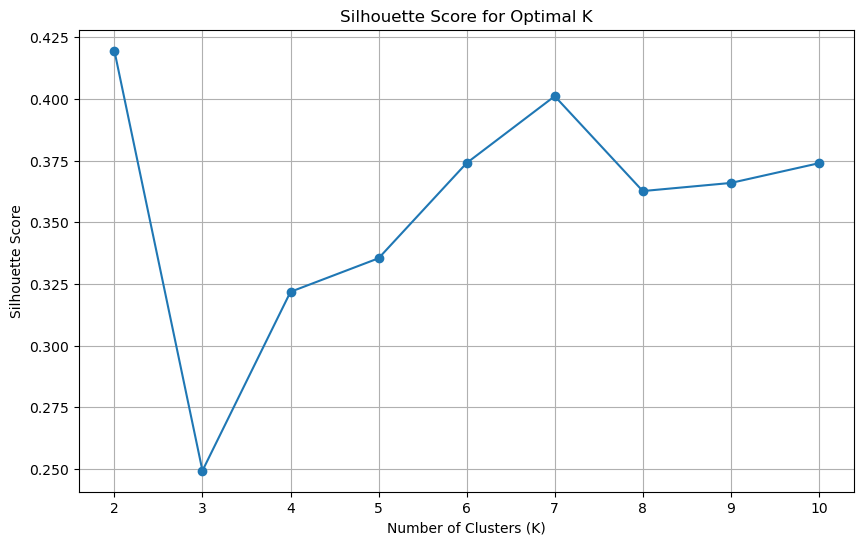

In [62]:
# Ensure all features are numeric
if not np.issubdtype(X.values.dtype, np.number):
    print("Error: Non-numeric data found in features for clustering.")
else:
    print(f"\nFeatures selected for clustering. Shape: {X.shape}")
    #Clustering Model Selection & Training
    # Determine optimal number of clusters for K-Means using Elbow Method and Silhouette Score
    sse = []
    k_range = range(2, 11)  # Test K from 2 to 10
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        try:
            kmeans.fit(X)
            sse.append(kmeans.inertia_)
        except ValueError as e:
            print(f"ValueError for K={k}: {e}")
            sse.append(np.nan)  # Append NaN if fitting fails
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('SSE (Sum of Squared Errors)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

# Silhouette Score
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    try:
        cluster_labels = kmeans.fit_predict(X)
        if len(np.unique(cluster_labels)) > 1:  # Silhouette score requires more than 1 cluster
            score = silhouette_score(X, cluster_labels)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)  # Indicate invalid score
    except ValueError as e:
        print(f"ValueError for K={k}: {e}")
        silhouette_scores.append(np.nan)  # Append NaN if fitting fails

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [83]:
# Based on the plots, choose an optimal K (e.g., 4 or 5, this is subjective and depends on the data)
optimal_k = 2  # Example: Let's assume 2 based on typical elbow/silhouette patterns

# K-Means Clustering
print(f"\nApplying K-Means with optimal_k = {optimal_k}")
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['kmeans_cluster'] = kmeans_model.fit_predict(X)
print("K-Means clustering complete.")
print(df['kmeans_cluster'].value_counts().sort_index())

# Hierarchical Clustering
print("\nApplying Hierarchical Clustering (AgglomerativeClustering)")
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward', metric='euclidean')
df['agg_cluster'] = agg_clustering.fit_predict(X)
print("Hierarchical clustering complete.")
print(df['agg_cluster'].value_counts().sort_index())

# DBSCAN
print("\nApplying DBSCAN (with example parameters)")
dbscan = DBSCAN(eps=0.5, min_samples=5)  # These parameters need tuning for your specific data
df['dbscan_cluster'] = dbscan.fit_predict(X)
print("DBSCAN clustering complete.")
print(df['dbscan_cluster'].value_counts().sort_index())


Applying K-Means with optimal_k = 2
K-Means clustering complete.
kmeans_cluster
0     594
1    7193
Name: count, dtype: int64

Applying Hierarchical Clustering (AgglomerativeClustering)
Hierarchical clustering complete.
agg_cluster
0    7249
1     538
Name: count, dtype: int64

Applying DBSCAN (with example parameters)
DBSCAN clustering complete.
dbscan_cluster
-1     461
 0      15
 1     617
 2     270
 3     107
      ... 
 90      5
 91      5
 92      6
 93      4
 94      5
Name: count, Length: 96, dtype: int64


In [85]:
#Model Training & Optimization (Dimensionality Reduction for Visualization)
# PCA for 2D visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)
df['pca_1'] = X_pca_2d[:, 0]
df['pca_2'] = X_pca_2d[:, 1]
print("\nPCA for 2D visualization complete.")


PCA for 2D visualization complete.


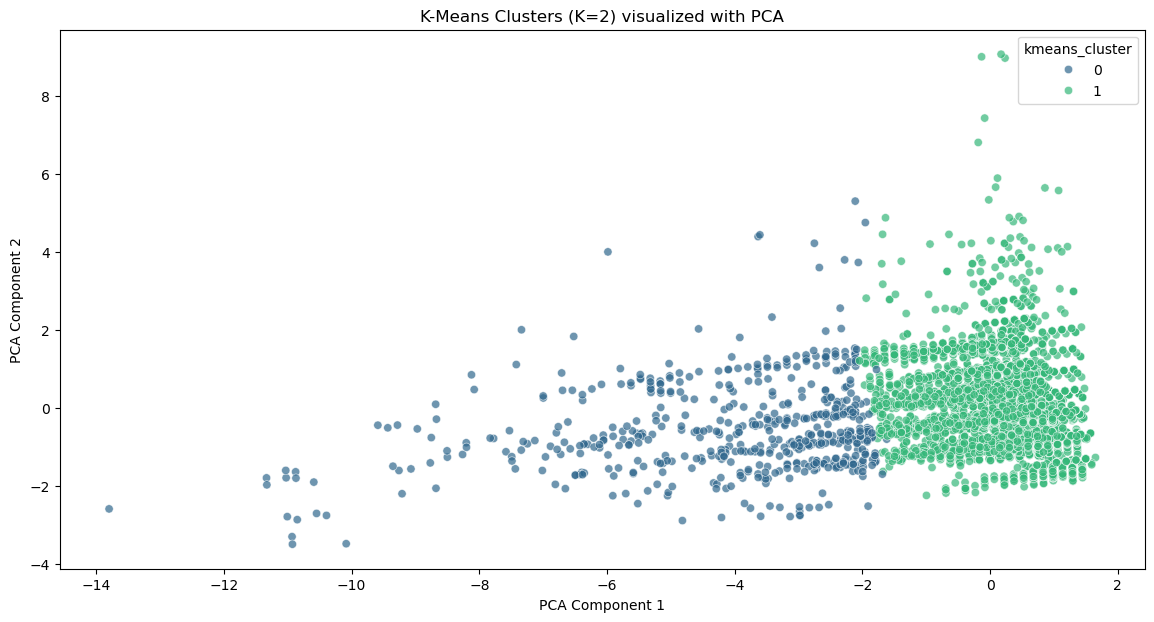


Most Common Genres per K-Means Cluster:

Cluster 0:
listed_in
Dramas                  241
International Movies    195
Comedies                183
Action & Adventure      142
Classic Movies          102
Name: count, dtype: int64

Cluster 1:
listed_in
International Movies      2242
Dramas                    1865
Comedies                  1288
International TV Shows    1188
Documentaries              757
Name: count, dtype: int64


In [86]:
#Visualization & Interpretation
# Cluster plots (using PCA for K-Means clusters)
plt.figure(figsize=(14, 7))
sns.scatterplot(x='pca_1', y='pca_2', hue='kmeans_cluster', data=df, palette='viridis', legend='full', alpha=0.7)
plt.title(f'K-Means Clusters (K={optimal_k}) visualized with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Interpretation: Most common genres per group (for K-Means)
print("\nMost Common Genres per K-Means Cluster:")
for cluster_id in sorted(df['kmeans_cluster'].unique()):
    cluster_data = df[df['kmeans_cluster'] == cluster_id]
    genres = cluster_data['listed_in'].str.split(', ').explode().value_counts().nlargest(5)
    print(f"\nCluster {cluster_id}:")
    print(genres)

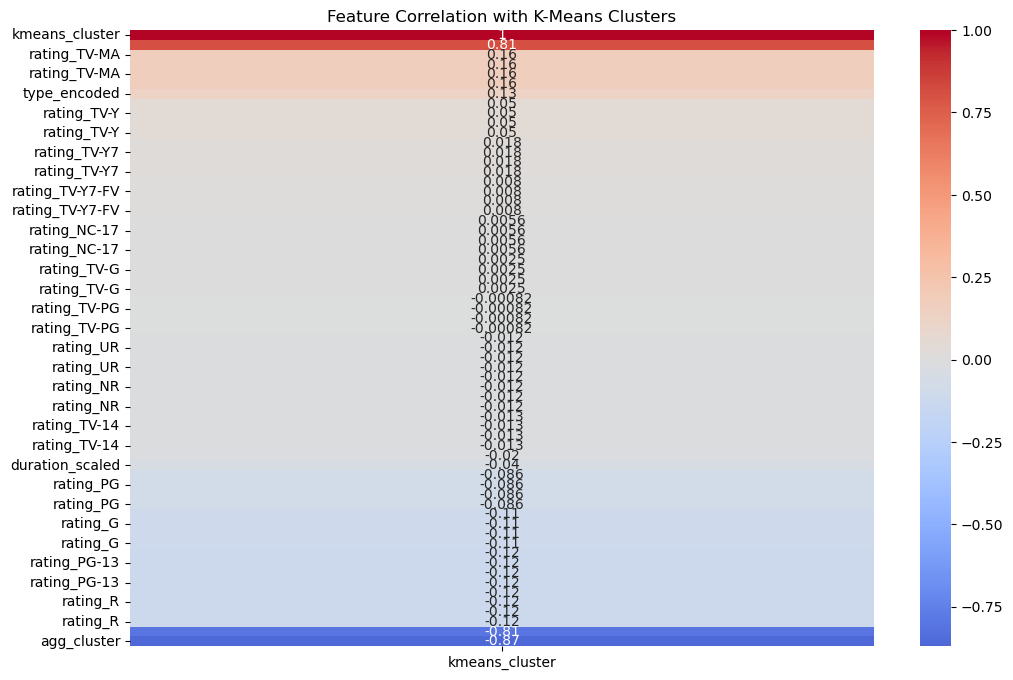

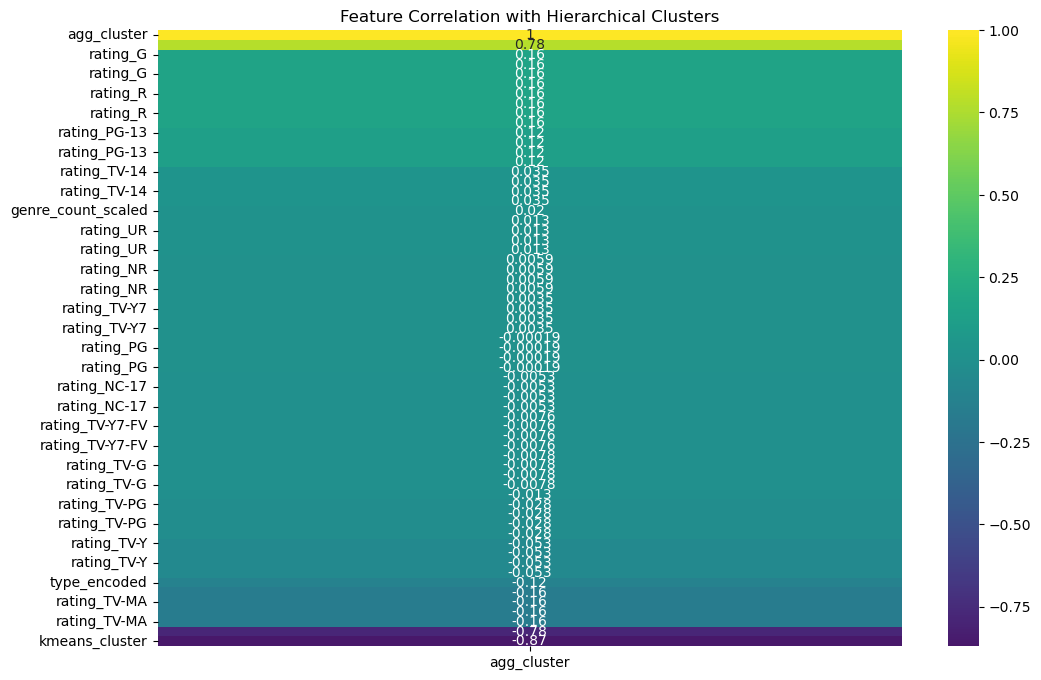

In [87]:
#Heatmap: Correlation with Clusters

# Selecting numeric features used in clustering, cluster labels
cluster_corr_df = df[features_for_clustering + ['kmeans_cluster', 'agg_cluster']].copy()

# Compute correlation matrix
correlation_matrix = cluster_corr_df.corr()

# Correlation with KMeans clusters
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['kmeans_cluster']].sort_values(by='kmeans_cluster', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with K-Means Clusters')
plt.show()

# Correlation with Hierarchical Clusteres
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix[['agg_cluster']].sort_values(by='agg_cluster', ascending=False),
            annot=True, cmap='viridis', center=0)
plt.title('Feature Correlation with Hierarchical Clusters')
plt.show()

In [88]:
#Evaluation & Refinement
#Evaluate K-Means
kmeans_silhouette = silhouette_score(X, df['kmeans_cluster'])
kmeans_davies_bouldin = davies_bouldin_score(X, df['kmeans_cluster'])
kmeans_inertia = kmeans_model.inertia_
print(f"\nK-Means Evaluation (K={optimal_k}):")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_davies_bouldin:.4f}")
print(f"  Inertia (SSE): {kmeans_inertia:.2f}")

# Evaluate Hierarchical Clustering
agg_labels = df['agg_cluster']
agg_silhouette = silhouette_score(X, agg_labels)
agg_davies_bouldin = davies_bouldin_score(X, agg_labels)
print(f"\nHierarchical Clustering Evaluation (K={optimal_k}):")
print(f"  Silhouette Score: {agg_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {agg_davies_bouldin:.4f}")

# Evaluate DBSCAN
dbscan_labels = df['dbscan_cluster']
core_samples_mask = dbscan_labels != -1
if np.sum(core_samples_mask) > 1 and len(np.unique(dbscan_labels[core_samples_mask])) > 1:
    dbscan_silhouette = silhouette_score(X[core_samples_mask], dbscan_labels[core_samples_mask])
    dbscan_davies_bouldin = davies_bouldin_score(X[core_samples_mask], dbscan_labels[core_samples_mask])
    print(f"\nDBSCAN Evaluation:")
    print(f"  Silhouette Score (excluding noise): {dbscan_silhouette:.4f}")
    print(f"  Davies-Bouldin Index (excluding noise): {dbscan_davies_bouldin:.4f}")
else:
    print("\nDBSCAN: Not enough non-noise clusters for Silhouette/Davies-Bouldin score.")


K-Means Evaluation (K=2):
  Silhouette Score: 0.4195
  Davies-Bouldin Index: 1.1999
  Inertia (SSE): 46544.64

Hierarchical Clustering Evaluation (K=2):
  Silhouette Score: 0.4103
  Davies-Bouldin Index: 1.1781

DBSCAN Evaluation:
  Silhouette Score (excluding noise): 0.4525
  Davies-Bouldin Index (excluding noise): 0.6979


In [89]:
#According to Silhouette Score, Davies-Bouldin Index the *K-means* is the best model for Netflix content categorization